<a href="https://colab.research.google.com/github/devu294/Cell-Image-Classification-using-Pytorch/blob/main/Cell_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive

MyDrive


In [ ]:
import os

zip_path = '/content/drive/MyDrive/Histopathologic Cancer Detection/histopathologic_cancer_detection.zip'

if os.path.exists(zip_path):
    print("File found!")
else:
    print("File not found.")

File found!


In [ ]:
import os

size_mb = os.path.getsize(zip_path) / (1024 * 1024)
print(f"File size: {size_mb:.2f} MB")

File size: 6459.45 MB


In [ ]:
# adjust these paths if your dataset is elsewhere
zip_path = '/content/drive/MyDrive/Histopathologic Cancer Detection/histopathologic_cancer_detection.zip'
data_root = '/content/histopathologic_data'

In [ ]:
# 2) Unzip dataset if not already extracted
import os, zipfile
if not os.path.exists(data_root):
    os.makedirs(data_root, exist_ok=True)
    if os.path.exists(zip_path):
        print('Unzipping...')
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(data_root)
        print('Unzipped to', data_root)
    else:
        print('Zip not found at', zip_path, '\nIf your data is already in Drive as a folder, set data_root accordingly.')
else:
    print('Data root exists:', data_root)

Unzipping...
Unzipped to /content/histopathologic_data


In [ ]:
# 3) Inspect data root and locate train images / labels
!ls -la "$data_root" | sed -n '1,200p'

import pandas as pd, os
csv_path = os.path.join(data_root, 'train_labels.csv')
print('\nChecking for labels CSV at', csv_path)
print('CSV exists?', os.path.exists(csv_path))

total 32268
drwxr-xr-x 4 root root     4096 Oct 31 01:52 .
drwxr-xr-x 1 root root     4096 Oct 31 01:49 ..
-rw-r--r-- 1 root root  2470703 Oct 31 01:49 sample_submission.csv
drwxr-xr-x 2 root root  4366336 Oct 31 01:50 test
drwxr-xr-x 2 root root 16719872 Oct 31 01:52 train
-rw-r--r-- 1 root root  9461084 Oct 31 01:52 train_labels.csv

Checking for labels CSV at /content/histopathologic_data/train_labels.csv
CSV exists? True


In [ ]:
# 4) Build dataframe of image paths and labels (handles CSV or folder-structured labels)
import os, pandas as pd, glob

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    # Expecting columns: id,label
    if 'id' in df.columns:
        # Assuming IDs in CSV do not have extensions, search for .png or .tif
        image_paths = []
        labels = []
        train_dir = os.path.join(data_root, 'train')
        missing_files = []
        for index, row in df.iterrows():
            img_id = str(row['id'])
            label = row['label']
            # Check for .png and .tif extensions
            png_path = os.path.join(train_dir, img_id + '.png')
            tif_path = os.path.join(train_dir, img_id + '.tif')

            if os.path.exists(png_path):
                image_paths.append(png_path)
                labels.append(label)
            elif os.path.exists(tif_path):
                image_paths.append(tif_path)
                labels.append(label)
            else:
                missing_files.append(img_id)
                # If neither exists, this image will be skipped

        df = pd.DataFrame({'path': image_paths, 'label': labels})

        # Add print statements to inspect paths
        print("Example paths found:")
        for i in range(min(5, len(df))):
            print(df.iloc[i]['path'])

        if missing_files:
            print(f"\nWarning: {len(missing_files)} files listed in CSV were not found as .png or .tif in the train directory. Examples:")
            for i in range(min(10, len(missing_files))):
                print(missing_files[i])

    else:
        print('CSV present but no "id" column; showing head:'); display(df.head())
else:
    # fallback: search for image files and infer labels from parent folder name if possible
    paths = []
    labels = []
    for root, dirs, files in os.walk(data_root):
        for f in files:
            if f.lower().endswith(('.png','.jpg','.jpeg', '.tif')): # Added .tif
                fp = os.path.join(root, f)
                parent = os.path.basename(os.path.dirname(fp))
                lab = None
                if parent in ['0','1']:
                    lab = int(parent)
                elif parent.lower() in ['cancer','tumor','malignant','1']:
                    lab = 1
                elif parent.lower() in ['normal','non-cancer','benign','0']:
                    lab = 0
                if lab is None:
                    continue
                paths.append(fp); labels.append(lab)
    df = pd.DataFrame({'path': paths, 'label': labels})

print('Total images found:', len(df))
display(df.head())

Example paths found:
/content/histopathologic_data/train/f38a6374c348f90b587e046aac6079959adf3835.tif
/content/histopathologic_data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
/content/histopathologic_data/train/755db6279dae599ebb4d39a9123cce439965282d.tif
/content/histopathologic_data/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
/content/histopathologic_data/train/068aba587a4950175d04c680d38943fd488d6a9d.tif
Total images found: 220025


,path,label
0,/content/histopathologic_data/train/f38a6374c3...,0
1,/content/histopathologic_data/train/c18f2d887b...,1
2,/content/histopathologic_data/train/755db6279d...,0
3,/content/histopathologic_data/train/bc3f0c64fb...,0
4,/content/histopathologic_data/train/068aba587a...,0


In [ ]:
# 5) Dataset, transforms, dataloaders
!pip install -q torch torchvision tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class HistoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            label = int(row['label'])
            return img, label
        except FileNotFoundError:
            logger.error(f"FileNotFoundError: Could not find image at path: {img_path}")
            # Return None or a placeholder if a file is not found,
            # depending on how you want to handle missing files during training.
            # For now, we'll re-raise after logging to stop execution and inspect.
            raise
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {e}")
            raise


# split - use the corrected df directly
val_frac = 0.1
dataset_full = HistoDataset(df, transform=train_transforms) # Use df directly
val_size = int(len(dataset_full) * val_frac)
train_size = len(dataset_full) - val_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# ensure val uses val_transforms
val_ds.dataset.transform = val_transforms

BATCH_SIZE = 32
# Keep num_workers at 0 for debugging
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print('Train/Val sizes:', len(train_ds), len(val_ds))

Train/Val sizes: 198023 22002


In [ ]:
# 6) Model (transfer learning ResNet18) - common, efficient, and similar to many kaggle notebooks
import torch.nn as nn
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def create_model(num_classes=2, pretrained=True, freeze_backbone=False):
    model = models.resnet18(pretrained=pretrained)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    nfeat = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(nfeat, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

model = create_model(num_classes=2, pretrained=True, freeze_backbone=False).to(device)


Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 78.3MB/s]


In [ ]:
# 7) Training loop: train + validate + checkpoint best model
import torch.optim as optim
from tqdm import tqdm
import copy
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

EPOCHS = 8
best_val_loss = float('inf')
save_path = '/content/best_merged_model.pth'

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0; train_correct = 0; total = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} train')
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds==labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=loss.item(), acc=f'{train_correct/total:.4f}')
    train_loss = train_loss / total; train_acc = train_correct / total

    # validation
    model.eval()
    val_loss = 0.0; val_correct = 0; vtotal = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs,1)
            val_correct += (preds==labels).sum().item()
            vtotal += imgs.size(0)
    val_loss = val_loss / vtotal; val_acc = val_correct / vtotal

    print(f'Epoch {epoch} | train_loss {train_loss:.4f} acc {train_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f}')
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch},
                   save_path)
        print('Saved best model to', save_path)

Epoch 1 train: 100%|██████████| 6189/6189 [20:17<00:00,  5.09it/s, acc=0.9393, loss=0.0237]


Epoch 1 | train_loss 0.1643 acc 0.9393 | val_loss 0.1402 acc 0.9502
Saved best model to /content/best_merged_model.pth


Epoch 2 train: 100%|██████████| 6189/6189 [19:40<00:00,  5.24it/s, acc=0.9644, loss=0.00414]


Epoch 2 | train_loss 0.1013 acc 0.9644 | val_loss 0.0877 acc 0.9692
Saved best model to /content/best_merged_model.pth


Epoch 3 train: 100%|██████████| 6189/6189 [19:40<00:00,  5.24it/s, acc=0.9744, loss=0.0173]


Epoch 3 | train_loss 0.0730 acc 0.9744 | val_loss 0.0917 acc 0.9685


Epoch 4 train: 100%|██████████| 6189/6189 [19:33<00:00,  5.28it/s, acc=0.9817, loss=0.000506]


Epoch 4 | train_loss 0.0532 acc 0.9817 | val_loss 0.0926 acc 0.9687


Epoch 5 train: 100%|██████████| 6189/6189 [19:24<00:00,  5.31it/s, acc=0.9860, loss=0.256]


Epoch 5 | train_loss 0.0396 acc 0.9860 | val_loss 0.0934 acc 0.9700


Epoch 6 train: 100%|██████████| 6189/6189 [19:30<00:00,  5.29it/s, acc=0.9888, loss=0.00134]


Epoch 6 | train_loss 0.0312 acc 0.9888 | val_loss 0.1118 acc 0.9660


Epoch 7 train: 100%|██████████| 6189/6189 [19:35<00:00,  5.26it/s, acc=0.9957, loss=0.958]


Epoch 7 | train_loss 0.0126 acc 0.9957 | val_loss 0.1067 acc 0.9748


Epoch 8 train: 100%|██████████| 6189/6189 [19:36<00:00,  5.26it/s, acc=0.9968, loss=3.25e-6]


Epoch 8 | train_loss 0.0092 acc 0.9968 | val_loss 0.1248 acc 0.9751


In [ ]:
# Verify image file paths in the DataFrame
import os

def check_file_exists(path):
    return os.path.exists(path)

# Apply the check to the 'path' column
df['exists'] = df['path'].apply(check_file_exists)

# Filter out rows where the file does not exist
df_filtered = df[df['exists']].drop(columns=['exists'])

print(f"Original number of images: {len(df)}")
print(f"Number of images found: {len(df_filtered)}")

# Update the dataset with the filtered dataframe
dataset_full = HistoDataset(df_filtered, transform=train_transforms)

# Split and create dataloaders as before
val_size = int(len(dataset_full) * val_frac)
train_size = len(dataset_full) - val_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# ensure val uses val_transforms
val_ds.dataset.transform = val_transforms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print('Train/Val sizes after filtering:', len(train_ds), len(val_ds))

Original number of images: 220025
Number of images found: 220025
Train/Val sizes after filtering: 198023 22002


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Verify image file paths in the DataFrame
import os

def check_file_exists(path):
    return os.path.exists(path)

# Apply the check to the 'path' column
df['exists'] = df['path'].apply(check_file_exists)

# Filter out rows where the file does not exist
df_filtered = df[df['exists']].drop(columns=['exists'])

print(f"Original number of images: {len(df)}")
print(f"Number of images found: {len(df_filtered)}")

# Update the dataset with the filtered dataframe
dataset_full = HistoDataset(df_filtered, transform=train_transforms)

# Split and create dataloaders as before
val_size = int(len(dataset_full) * val_frac)
train_size = len(dataset_full) - val_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# ensure val uses val_transforms
val_ds.dataset.transform = val_transforms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print('Train/Val sizes after filtering:', len(train_ds), len(val_ds))

Original number of images: 220025
Number of images found: 220025
Train/Val sizes after filtering: 198023 22002


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 8) Grad-CAM implementation (simple) for ResNet-type model
import torch.nn.functional as F
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        outputs = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1).item()
        score = outputs[0, class_idx]
        score.backward(retain_graph=True)
        grads = self.gradients[0]
        acts = self.activations[0]
        weights = torch.mean(grads, dim=(1,2))
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(acts.device)
        for i, w in enumerate(weights):
            cam += w * acts[i]
        cam = F.relu(cam)
        cam = cam.cpu().numpy()
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (input_tensor.shape[-1], input_tensor.shape[-2]))
        return cam

    def close(self):
        for h in self.hook_handles:
            h.remove()

Saving download.jpg to download.jpg
Uploaded: download.jpg
Prediction: 0 non-cancer prob=0.9488


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


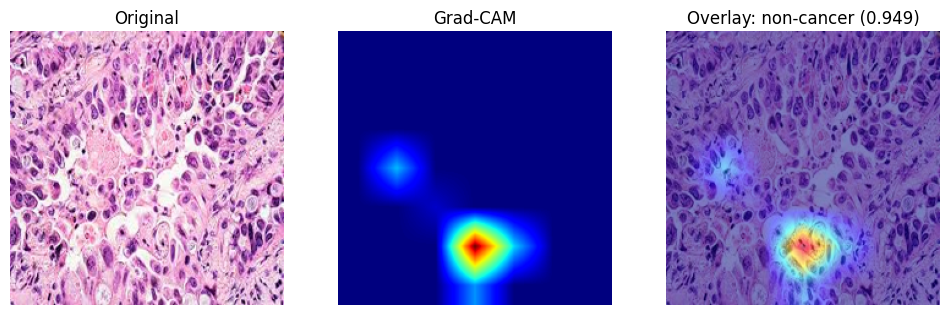

In [ ]:
# 9) Inference on a local uploaded image + Grad-CAM overlay
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

def preprocess_image(pil_img, size=IMG_SIZE):
    tf = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    return tf(pil_img).unsqueeze(0).to(device)

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    overlay = heatmap * alpha + img * (1-alpha)
    overlay = overlay / overlay.max()
    return overlay

# upload local image
uploaded = files.upload()
local_fname = list(uploaded.keys())[0]
print('Uploaded:', local_fname)
pil = Image.open(local_fname).convert('RGB')
inp = preprocess_image(pil)

# load model checkpoint if exists
if os.path.exists('/content/best_merged_model.pth'):
    ck = torch.load('/content/best_merged_model.pth', map_location=device)
    model.load_state_dict(ck['model_state_dict'])
    model.to(device)
    model.eval()

# select target layer for ResNet
target_layer = model.layer4[-1].conv2
gcam = GradCAM(model, target_layer=target_layer)

with torch.no_grad():
    out = model(inp)
    probs = torch.softmax(out, dim=1).cpu().numpy()[0]
    pred = int(np.argmax(probs))
label_map = {0: 'non-cancer', 1: 'cancer'}
print('Prediction:', pred, label_map[pred], f'prob={probs[pred]:.4f}')

cam_mask = gcam.generate(inp, class_idx=pred)
orig = np.array(pil.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0
overlay = show_cam_on_image(orig, cam_mask, alpha=0.5)

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(orig); axs[0].axis('off'); axs[0].set_title('Original')
axs[1].imshow(cam_mask, cmap='jet'); axs[1].axis('off'); axs[1].set_title('Grad-CAM')
axs[2].imshow(overlay); axs[2].axis('off'); axs[2].set_title(f'Overlay: {label_map[pred]} ({probs[pred]:.3f})')
plt.show()

gcam.close()

Saving 3rd-2023_Lisowska_Malgorzata_e30379_f20818.jpg to 3rd-2023_Lisowska_Malgorzata_e30379_f20818.jpg

📁 Uploaded: 3rd-2023_Lisowska_Malgorzata_e30379_f20818.jpg
🧠 Prediction: non-cancer  |  Confidence: 0.9933


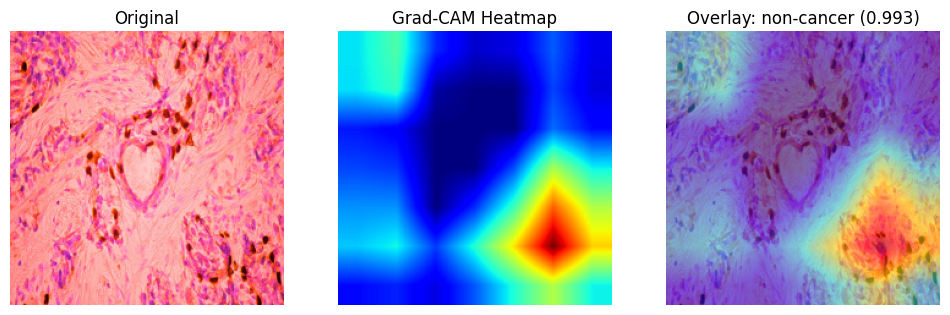


🔁 Do you want to upload another image? (y/n): y


Saving download.jpg to download (2).jpg

📁 Uploaded: download (2).jpg
🧠 Prediction: non-cancer  |  Confidence: 0.9488


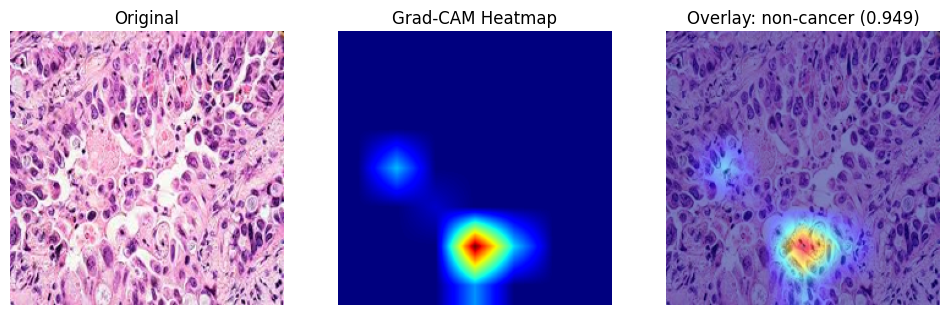


🔁 Do you want to upload another image? (y/n): y


Saving nm-brain-tumors-up-close_feature.jpg to nm-brain-tumors-up-close_feature.jpg

📁 Uploaded: nm-brain-tumors-up-close_feature.jpg
🧠 Prediction: non-cancer  |  Confidence: 0.6515


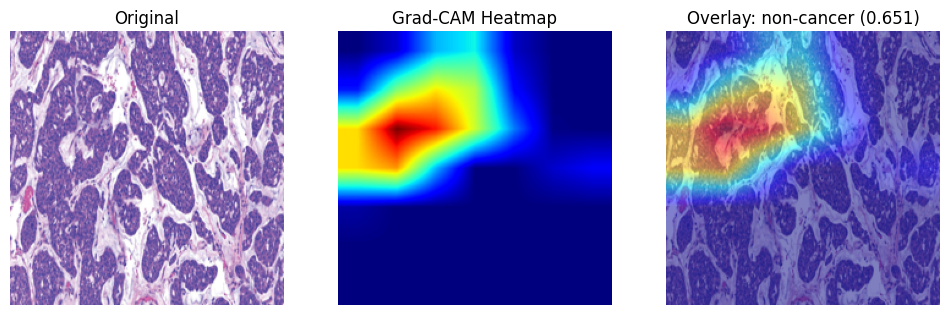


🔁 Do you want to upload another image? (y/n): y


Saving squamous_cell_carcinoma-08846c381afe737aa26e40fb06d9e9b6-1.webp to squamous_cell_carcinoma-08846c381afe737aa26e40fb06d9e9b6-1 (1).webp

📁 Uploaded: squamous_cell_carcinoma-08846c381afe737aa26e40fb06d9e9b6-1 (1).webp
🧠 Prediction: non-cancer  |  Confidence: 0.9747


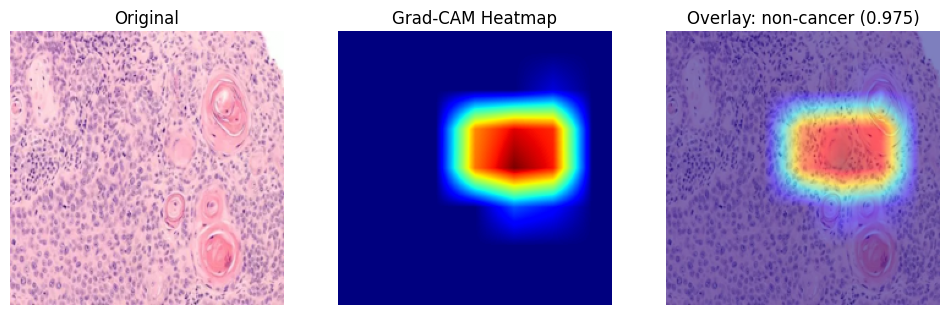


🔁 Do you want to upload another image? (y/n): n
✅ Exiting inference loop.


In [ ]:
# 9) Inference + Grad-CAM overlay (interactive loop)
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import cv2
import torch

def preprocess_image(pil_img, size=IMG_SIZE):
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return tf(pil_img).unsqueeze(0).to(device)

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay / overlay.max()
    return overlay

# load model checkpoint if exists
if os.path.exists('/content/best_merged_model.pth'):
    ck = torch.load('/content/best_merged_model.pth', map_location=device)
    model.load_state_dict(ck['model_state_dict'])
    model.to(device)
    model.eval()
else:
    print("⚠️ No saved model found at /content/best_merged_model.pth")

label_map = {0: 'non-cancer', 1: 'cancer'}

# GradCAM setup
target_layer = model.layer4[-1].conv2
gcam = GradCAM(model, target_layer=target_layer)

# interactive upload loop
while True:
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        break

    local_fname = list(uploaded.keys())[0]
    print(f"\n📁 Uploaded: {local_fname}")

    # preprocess and predict
    pil = Image.open(local_fname).convert('RGB')
    inp = preprocess_image(pil)

    with torch.no_grad():
        out = model(inp)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))

    print(f"🧠 Prediction: {label_map[pred]}  |  Confidence: {probs[pred]:.4f}")

    # Grad-CAM visualization
    cam_mask = gcam.generate(inp, class_idx=pred)
    orig = np.array(pil.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0
    overlay = show_cam_on_image(orig, cam_mask, alpha=0.5)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(orig)
    axs[0].axis('off')
    axs[0].set_title('Original')

    axs[1].imshow(cam_mask, cmap='jet')
    axs[1].axis('off')
    axs[1].set_title('Grad-CAM Heatmap')

    axs[2].imshow(overlay)
    axs[2].axis('off')
    axs[2].set_title(f'Overlay: {label_map[pred]} ({probs[pred]:.3f})')
    plt.show()

    # ask user if they want to continue
    again = input("\n🔁 Do you want to upload another image? (y/n): ").strip().lower()
    if again != 'y':
        print("✅ Exiting inference loop.")
        break

gcam.close()
